In [2]:
#!pip install numpy
#!pip install scipy
#!pip install torch
#!pip install torch_geometric
#!pip install matplotlib
#!pip install scikit-learn
#!pip install pandas
#!pip install torchmetrics

In [4]:
#!pip freeze > requirements.txt

In [5]:
# Install required packages.
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
def compute_homophily(edge_index, y):
    # Ensure edge_index is undirected
    row, col = edge_index
    same_label = (y[row] == y[col])
    return same_label.sum().item() / edge_index.size(1)

In [7]:
graph = torch.load('SMP_R_graph.pt', weights_only=False)
#graph = torch.load('GNG_graph.pt', weights_only=False)


In [8]:
homophily = compute_homophily(graph.edge_index, graph.y)
print(f"Homophily: {homophily:.4f}")

Homophily: 0.9326


In [9]:
num_classes = len(graph.y.unique())
num_classes

6

In [10]:
num_features = graph.x.shape[1]
num_nodes = graph.x.shape[0]

In [11]:
# Compute class weights
label_counts = torch.bincount(graph.y[graph.train_mask])
class_weights = 1.0 / label_counts.float()
class_weights = class_weights / class_weights.sum()  # normalize if you want

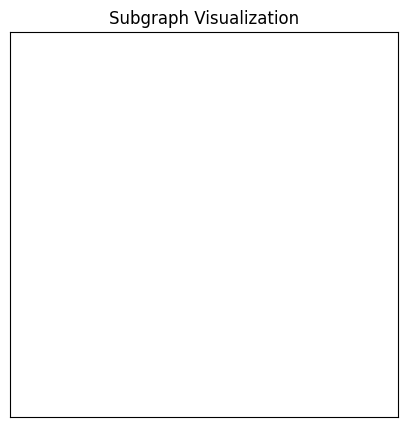

In [12]:
from torch_geometric.utils import subgraph, to_networkx
import networkx as nx

# Draw subgraph
plt.figure(figsize=(5, 5))
#nx.draw(G, with_labels=True, node_color="lightblue", edge_color="gray", node_size=100, font_size=8)
plt.xticks([])
plt.yticks([])
plt.title("Subgraph Visualization")
plt.show()

## Training a Graph Neural Network (GNN)

We can easily convert our MLP to a GNN by swapping the `torch.nn.Linear` layers with PyG's GNN operators.

Following-up on [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8), we replace the linear layers by the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) module.
To recap, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.
In contrast, a single `Linear` layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

which does not make use of neighboring node information.

In [13]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)  # Dropout only active during training
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(6, 16)
  (conv2): GCNConv(16, 6)
)


In [14]:
import torch.nn.functional as F

from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
#criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(graph.x, graph.edge_index)  # Perform a single forward pass.
      loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.

      # --- Validation error ---
      model.eval()  # switch to eval mode (disables dropout, etc.)
      with torch.no_grad():
            pred = out.argmax(dim=1)
            val_pred = pred[graph.val_mask]
            val_true = graph.y[graph.val_mask]
            val_acc = (val_pred == val_true).float().mean().item()
    
      return loss.item(), val_acc

def test():
      model.eval()
      out = model(graph.x, graph.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[graph.test_mask] == graph.y[graph.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(graph.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 1001):
    loss, val_acc = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, val_error: {val_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.7816, val_error: 0.5383
Epoch: 002, Loss: 1.7822, val_error: 0.6253
Epoch: 003, Loss: 1.8085, val_error: 0.5280
Epoch: 004, Loss: 1.7932, val_error: 0.4887
Epoch: 005, Loss: 1.7917, val_error: 0.4501
Epoch: 006, Loss: 1.7743, val_error: 0.4048
Epoch: 007, Loss: 1.7606, val_error: 0.3548
Epoch: 008, Loss: 1.7464, val_error: 0.3119
Epoch: 009, Loss: 1.7360, val_error: 0.3178
Epoch: 010, Loss: 1.7419, val_error: 0.3083
Epoch: 011, Loss: 1.7337, val_error: 0.3067
Epoch: 012, Loss: 1.7335, val_error: 0.2332
Epoch: 013, Loss: 1.7430, val_error: 0.2626
Epoch: 014, Loss: 1.7378, val_error: 0.2567
Epoch: 015, Loss: 1.7194, val_error: 0.2630
Epoch: 016, Loss: 1.7201, val_error: 0.2710
Epoch: 017, Loss: 1.7117, val_error: 0.2749
Epoch: 018, Loss: 1.7131, val_error: 0.2765
Epoch: 019, Loss: 1.6748, val_error: 0.2833
Epoch: 020, Loss: 1.6916, val_error: 0.2813
Epoch: 021, Loss: 1.7191, val_error: 0.2896
Epoch: 022, Loss: 1.6938, val_error: 0.2841
Epoch: 023, Loss: 1.6722, val_er

In [15]:
from sklearn.metrics import classification_report

# Assume:
# - y_true: ground truth labels of test nodes
# - y_pred: predicted labels of test nodes

# Example:
y_pred = model(graph.x, graph.edge_index).argmax(dim=1)
y_true = graph.y

# Use the test mask to slice out test nodes
y_pred_test = y_pred[graph.test_mask]
y_true_test = y_true[graph.test_mask]

# Classification report (includes precision, recall, F1 per class)
report = classification_report(y_true_test.cpu(), y_pred_test.cpu(), digits=3, output_dict=True)
print("Classification Report:\n", report)

Classification Report:
 {'0': {'precision': 0.013888888888888888, 'recall': 0.058823529411764705, 'f1-score': 0.02247191011235955, 'support': 17.0}, '1': {'precision': 0.9584799437016186, 'recall': 0.5632754342431762, 'f1-score': 0.709559781193019, 'support': 2418.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 24.0}, '3': {'precision': 0.006756756756756757, 'recall': 0.0625, 'f1-score': 0.012195121951219513, 'support': 16.0}, '4': {'precision': 0.003778337531486146, 'recall': 0.1875, 'f1-score': 0.007407407407407408, 'support': 16.0}, '5': {'precision': 0.02631578947368421, 'recall': 0.038461538461538464, 'f1-score': 0.03125, 'support': 26.0}, 'accuracy': 0.5435041716328963, 'macro avg': {'precision': 0.1682032860587391, 'recall': 0.15176008368607988, 'f1-score': 0.13048070344400092, 'support': 2517.0}, 'weighted avg': {'precision': 0.921213105687943, 'recall': 0.5435041716328963, 'f1-score': 0.6822501842933526, 'support': 2517.0}}


In [16]:
#f1_weighted_GCN_GNG = report["weighted avg"]["f1-score"]
#f1_weighted_GCN_GNG
f1_weighted_GCN_SMP_R = report["weighted avg"]["f1-score"]
f1_weighted_GCN_SMP_R

0.6822501842933526

In [17]:
from torch_geometric.nn import GATConv

# Assuming num_features and num_classes are defined globally
# e.g., num_features = dataset.num_features, num_classes = dataset.num_classes

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(num_features, hidden_channels, heads=8, dropout=0.0)
        # Output dim of conv1 is hidden_channels * heads, so we set in_channels accordingly
        self.conv2 = GATConv(hidden_channels * 8, num_classes, heads=1, concat=False, dropout=0.0)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.5, training=self.training)  # Dropout only active during training
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=16)
print(model)

GAT(
  (conv1): GATConv(6, 16, heads=8)
  (conv2): GATConv(128, 6, heads=1)
)


In [18]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GAT(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
#criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(graph.x, graph.edge_index)  # Perform a single forward pass.
      loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.

      # --- Validation error ---
      model.eval()  # switch to eval mode (disables dropout, etc.)
      with torch.no_grad():
            pred = out.argmax(dim=1)
            val_pred = pred[graph.val_mask]
            val_true = graph.y[graph.val_mask]
            val_acc = (val_pred == val_true).float().mean().item()
    
      return loss.item(), val_acc

def test():
      model.eval()
      out = model(graph.x, graph.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[graph.test_mask] == graph.y[graph.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(graph.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 1001):
    loss, val_acc = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, val_error: {val_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.7874, val_error: 0.1442
Epoch: 002, Loss: 1.7570, val_error: 0.4998
Epoch: 003, Loss: 1.7265, val_error: 0.5419
Epoch: 004, Loss: 1.6803, val_error: 0.5538
Epoch: 005, Loss: 1.6605, val_error: 0.5157
Epoch: 006, Loss: 1.6137, val_error: 0.4648
Epoch: 007, Loss: 1.6030, val_error: 0.4025
Epoch: 008, Loss: 1.5797, val_error: 0.3603
Epoch: 009, Loss: 1.5633, val_error: 0.3031
Epoch: 010, Loss: 1.5104, val_error: 0.2634
Epoch: 011, Loss: 1.5064, val_error: 0.2169
Epoch: 012, Loss: 1.4755, val_error: 0.1824
Epoch: 013, Loss: 1.4715, val_error: 0.1474
Epoch: 014, Loss: 1.4086, val_error: 0.1232
Epoch: 015, Loss: 1.3895, val_error: 0.1188
Epoch: 016, Loss: 1.3811, val_error: 0.1152
Epoch: 017, Loss: 1.3708, val_error: 0.1116
Epoch: 018, Loss: 1.3325, val_error: 0.1045
Epoch: 019, Loss: 1.3117, val_error: 0.1156
Epoch: 020, Loss: 1.2997, val_error: 0.1065
Epoch: 021, Loss: 1.2633, val_error: 0.0989
Epoch: 022, Loss: 1.2514, val_error: 0.1045
Epoch: 023, Loss: 1.2328, val_er

In [19]:
# Assume:
# - y_true: ground truth labels of test nodes
# - y_pred: predicted labels of test nodes

# Example:
y_pred = model(graph.x, graph.edge_index).argmax(dim=1)
y_true = graph.y

# Use the test mask to slice out test nodes
y_pred_test = y_pred[graph.test_mask]
y_true_test = y_true[graph.test_mask]

# Classification report (includes precision, recall, F1 per class)
report = classification_report(y_true_test.cpu(), y_pred_test.cpu(), digits=3, output_dict=True)

In [20]:
#f1_weighted_GAT_GNG = report["weighted avg"]["f1-score"]
#f1_weighted_GAT_GNG
f1_weighted_GAT_SMP_R = report["weighted avg"]["f1-score"]
f1_weighted_GAT_SMP_R

0.7504512145764127

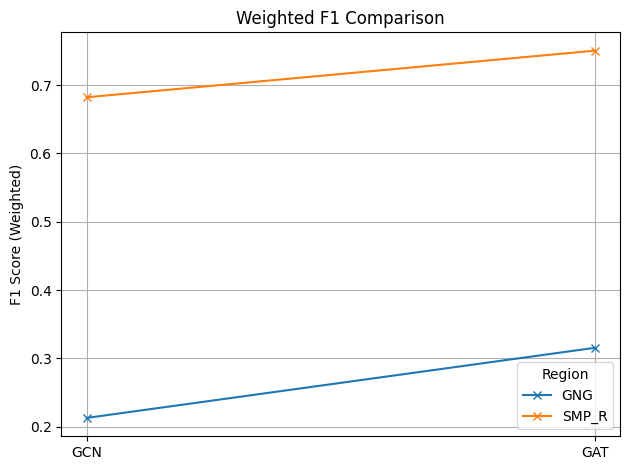

In [106]:
plt.plot([f1_weighted_GCN_GNG, f1_weighted_GAT_GNG], "x-", label="GNG")
plt.plot([f1_weighted_GCN_SMP_R, f1_weighted_GAT_SMP_R], "x-", label="SMP_R")

# Add x-ticks for GCN and GAT
plt.xticks([0, 1], ["GCN", "GAT"])
plt.ylabel("F1 Score (Weighted)")
plt.title("Weighted F1 Comparison")
plt.legend()
plt.legend(title="Region")  # Show line labels
plt.grid(True)
plt.tight_layout()
plt.savefig("f1_comparison.png", dpi=300, bbox_inches='tight')  # Save as PNG
plt.show()

In [21]:
from torch_geometric.nn.models import LabelPropagation

lp = LabelPropagation(num_layers=10, alpha=0.9)

# Run label propagation
y_pred = lp(graph.y, graph.edge_index, graph.train_mask)

# Convert soft outputs to class predictions
y_pred_labels = y_pred.argmax(dim=1)

# Compute accuracy on test set
acc = (y_pred_labels[graph.test_mask] == graph.y[graph.test_mask]).float().mean()
print(f"Label Propagation Accuracy: {acc:.4f}")


Label Propagation Accuracy: 0.7771


## Message passing

In [26]:
def simple_gcn(x, edge_index, weight):
    N = x.size(0)  # Number of nodes

    # Add self-loops
    loop_index = torch.arange(N)
    self_loops = loop_index.unsqueeze(0).repeat(2, 1)
    edge_index = torch.cat([edge_index, self_loops], dim=1)

    row, col = edge_index
    deg = torch.bincount(row, minlength=N).float()
    deg_inv_sqrt = deg.pow(-0.5)
    norm = (deg_inv_sqrt[row] * deg_inv_sqrt[col])

    # Linear transformation
    x = x @ weight

    # Initialize output
    out = torch.zeros_like(x)

    # Manual message passing
    for i in range(edge_index.size(1)):
        src = row[i]
        dst = col[i]
        out[dst] += norm[i] * x[src]

    return torch.relu(out)

In [27]:
from torch_geometric.data import Data

# Inputs
x = torch.tensor([
    [1.0, 0.0],
    [0.0, 1.0],
    [1.0, 1.0],
    [0.0, 0.0]
])

edge_index = torch.tensor([
    [0, 1, 1, 1, 2, 3],
    [1, 0, 2, 3, 1, 1]
], dtype=torch.long)

# Graph object for PyG
data = Data(x=x, edge_index=edge_index)

# Create PyG GCNConv layer
gcn = GCNConv(in_channels=2, out_channels=3, bias=False)

# Set the weights to match
W = torch.tensor([
    [0.1, 0.2, 0.3],
    [0.4, 0.5, 0.6]
], dtype=torch.float)

with torch.no_grad():
    gcn.lin.weight.copy_(W.T)

# Apply PyG GCN
out_pyg = gcn(data.x, data.edge_index)
out_pyg = torch.relu(out_pyg)

In [28]:
# Run custom GCN
out_custom = simple_gcn(x, edge_index, W)

# Compare
print("Custom GCN Output:\n", out_custom)
print("\nPyG GCNConv Output:\n", out_pyg)

print("\nAre they close?", torch.allclose(out_custom, out_pyg, atol=1e-5))


Custom GCN Output:
 tensor([[0.1914, 0.2768, 0.3621],
        [0.3121, 0.4432, 0.5743],
        [0.3914, 0.5268, 0.6621],
        [0.1414, 0.1768, 0.2121]])

PyG GCNConv Output:
 tensor([[0.1914, 0.2768, 0.3621],
        [0.3121, 0.4432, 0.5743],
        [0.3914, 0.5268, 0.6621],
        [0.1414, 0.1768, 0.2121]], grad_fn=<ReluBackward0>)

Are they close? True
